[*********************100%%**********************]  10 of 10 completed


Optimal Portfolio Weights:
BTC-USD: 60.00%
ETH-USD: 20.00%
MKR-USD: 2.00%
GFI-USD: 2.00%
AGIX-USD: 5.00%
FET-USD: 3.00%
SOL-USD: 2.00%
ADA-USD: 2.00%
MATIC-USD: 2.00%
OP-USD: 2.00%

Portfolio Return: 1529.46%
Portfolio Volatility: 2407.88%
Sharpe Ratio: 0.64


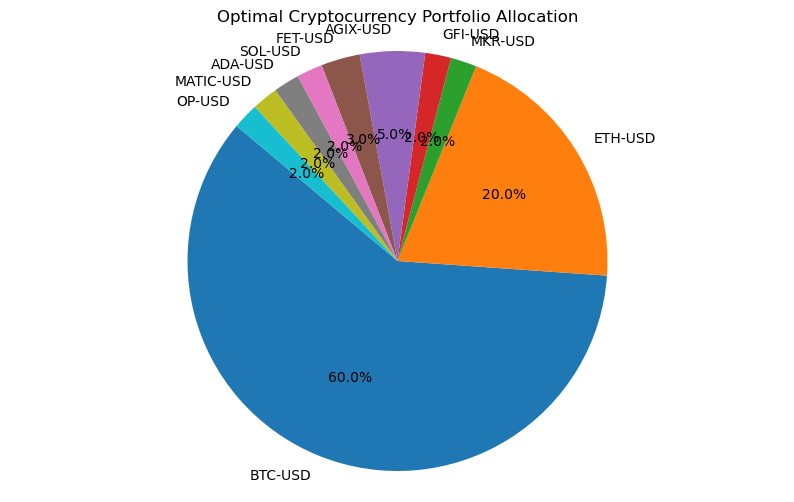

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Define Cryptocurrencies and Narratives
cryptos = {
    'Bitcoin': ['BTC-USD'],  # Bitcoin
    'Ethereum': ['ETH-USD'],  # Ethereum
    'RWA': ['MKR-USD', 'GFI-USD'],  # Real-World Assets
    'AI': ['AGIX-USD', 'FET-USD'],  # Artificial Intelligence
    'Layer 1': ['SOL-USD', 'ADA-USD'],  # Layer 1 Protocols
    'Layer 2': ['MATIC-USD', 'OP-USD']  # Layer 2 Ethereum Protocols
}

# Step 2: Download Cryptocurrency Data
all_crypto_symbols = [symbol for narrative in cryptos.values() for symbol in narrative]
data = yf.download(all_crypto_symbols, start='2018-01-01')['Adj Close'].dropna()

# Step 3: Calculate Daily Returns
returns = data.pct_change().dropna()

# Step 4: Define Portfolio Metrics Function
def portfolio_metrics(weights, returns, risk_free_rate):
    weights = np.array(weights)
    annual_factor = 365
    portfolio_return = np.dot(weights, returns.mean()) * annual_factor
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights))) * np.sqrt(annual_factor)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return portfolio_return, portfolio_std_dev, sharpe_ratio

# Risk-free rate (10-year Treasury yield, converted to daily)
risk_free_rate = 0.04 / 365  # Example: 4% annualized rate

# Step 5: Define Objective Function (Negative Sharpe Ratio for Minimization)
def negative_sharpe_ratio(weights, returns, risk_free_rate):
    _, _, sharpe = portfolio_metrics(weights, returns, risk_free_rate)
    return -sharpe

# Step 6: Constraints and Bounds
num_assets = len(all_crypto_symbols)
bounds = [(0, 1) for _ in range(num_assets)]  # Weights between 0 and 1
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights = 1
    {'type': 'ineq', 'fun': lambda weights: weights[0] - 0.60},  # BTC ≥ 60%
    {'type': 'ineq', 'fun': lambda weights: 0.20 - weights[1]},  # ETH ≤ 20%
    {'type': 'ineq', 'fun': lambda weights: weights[4] - 0.05},  # SOL ≥ 5%
]

# Add narrative constraints
narrative_start = 2  # First index for narratives
narrative_end = num_assets
for i in range(narrative_start, narrative_end):
    constraints.append({'type': 'ineq', 'fun': lambda weights, i=i: weights[i] - 0.02})  # Each narrative ≥ 2%

# Initial Guess
initial_weights = np.array([0.60 if i == 0 else 0.10 if i == 1 else (1 - 0.70) / (num_assets - 2) for i in range(num_assets)])

# Step 7: Optimization
optimized = minimize(
    fun=negative_sharpe_ratio,
    x0=initial_weights,
    args=(returns, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Optimal Weights
optimal_weights = optimized.x
portfolio_return, portfolio_std_dev, portfolio_sharpe = portfolio_metrics(optimal_weights, returns, risk_free_rate)

# Step 8: Display Results
print("Optimal Portfolio Weights:")
for i, symbol in enumerate(all_crypto_symbols):
    print(f"{symbol}: {optimal_weights[i]:.2%}")

print(f"\nPortfolio Return: {portfolio_return:.2%}")
print(f"Portfolio Volatility: {portfolio_std_dev:.2%}")
print(f"Sharpe Ratio: {portfolio_sharpe:.2f}")

# Step 9: Visualization
plt.figure(figsize=(10, 6))
plt.pie(optimal_weights, labels=all_crypto_symbols, autopct='%1.1f%%', startangle=140)
plt.title('Optimal Cryptocurrency Portfolio Allocation')
plt.axis('equal')
plt.show()
